## sandbox workspace for function training 



In [ ]:
#TODO find jupyter notebook active .json file
# OLD one  jupyter cjonsole --existing /Users/alexdhawan/Library/Jupyter/runtime/kernel-v31d5d3e1bb3b9299281d46b504b7f05c953249474.json
# use "jupyter notebook --existing"

SyntaxError: invalid syntax (2119608793.py, line 3)

44100
(128, 2)


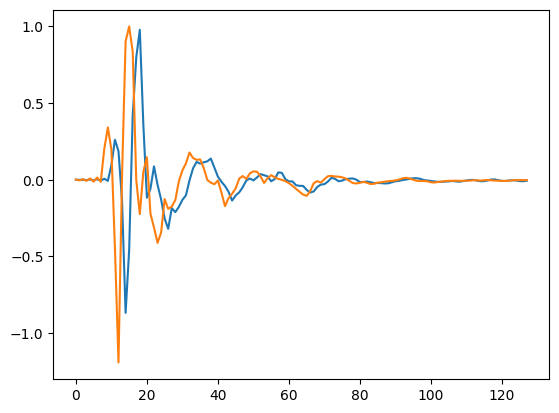

In [22]:
### from CHAT 
import pysofaconventions as sofa
import soundfile as sf
import numpy as np
import os
from scipy.io import wavfile
import matplotlib.pyplot as plt

os.chdir('/Users/alexdhawan/Desktop/ECE5730/ML-head-transfer-functions/python_training/scripts/')
sample_rate, data = wavfile.read('/Users/alexdhawan/Desktop/ECE5730/ML-head-transfer-functions/python_training/data/training_audio/raw/from_KEMAR/elev50/H50e008a.wav')

print(sample_rate)
print(data.shape)
plt.plot(data/data.max())
left = data[:,0]
right = data[:,1]

import feature_extract
ILD, ILD_time, t_samples = feature_extract.compute_ILD(left,right)


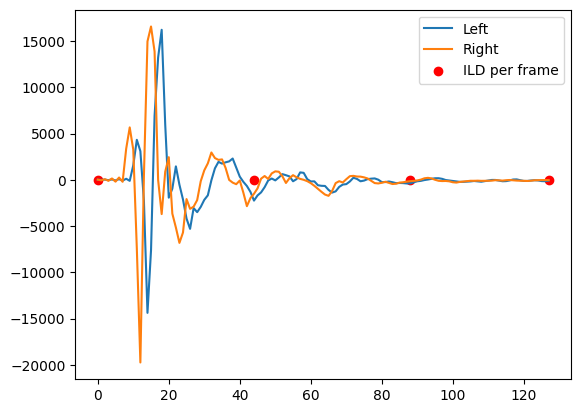

In [23]:

plt.figure()

plt.plot(left, label="Left")
plt.plot(right, label="Right")
plt.scatter(t_samples, ILD_time, color='red', label="ILD per frame")
plt.legend()
plt.show()
